<a href="https://colab.research.google.com/github/ThisaraKavinda/Catwalk_MAD/blob/master/Lip_reading_stage_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Install and Import Dependencies

In [1]:
# !pip install opencv-python matplotlib imageio gdown tensorflow

In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [5]:
import gdown

In [6]:
url = 'https://drive.google.com/uc?id=14kwGJeaoUUTOkO5l59ufiKfBme5XDs6z'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From: https://drive.google.com/uc?id=14kwGJeaoUUTOkO5l59ufiKfBme5XDs6z
To: /content/data.zip
100%|██████████| 160M/160M [00:06<00:00, 23.0MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/Aunty_01.align',
 'data/alignments/s1/Aunty_02.align',
 'data/alignments/s1/Aunty_03.align',
 'data/alignments/s1/Aunty_04.align',
 'data/alignments/s1/Aunty_05.align',
 'data/alignments/s1/Aunty_06.align',
 'data/alignments/s1/Aunty_07.align',
 'data/alignments/s1/Aunty_08.align',
 'data/alignments/s1/Aunty_09.align',
 'data/alignments/s1/Aunty_10.align',
 'data/alignments/s1/Deshitha_01.align',
 'data/alignments/s1/Deshitha_02.align',
 'data/alignments/s1/Deshitha_03.align',
 'data/alignments/s1/Deshitha_04.align',
 'data/alignments/s1/Deshitha_05.align',
 'data/alignments/s1/Deshitha_06.align',
 'data/alignments/s1/Deshitha_07.align',
 'data/alignments/s1/Deshitha_08.align',
 'data/alignments/s1/Deshitha_09.align',
 'data/alignments/s1/Deshitha_10.align',
 'data/alignments/s1/Hirusha_01.align',
 'data/alignments/s1/Hirusha_02.align',
 'data/alignments/s1/Hirusha_03.align',
 'data/alignments/s1/Hirusha_04.ali

In [7]:
def load_video(path:str) -> List[float]:
    # print(path)
    cap = cv2.VideoCapture(path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if frame_count != 35:
        raise ValueError(f"Video {path} has {frame_count} frames, but it should have 35 frames.")
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        # print(frame.shape, "=====", path)
        try:
            frame = tf.image.rgb_to_grayscale(frame)
            frames.append(frame[650:850,250:500,:])
        except tf.errors.InvalidArgumentError as e:
            continue
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [8]:
vocab = ["එ", "ක", "දෙ", "තු", "න", "හ", "ත", "ර", "ප", "ය", "අ", "ට", "ම", "ද"]

In [9]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'එ', 'ක', 'දෙ', 'තු', 'න', 'හ', 'ත', 'ර', 'ප', 'ය', 'අ', 'ට', 'ම', 'ද'] (size =15)


In [10]:
char_to_num.get_vocabulary()

['', 'එ', 'ක', 'දෙ', 'තු', 'න', 'හ', 'ත', 'ර', 'ප', 'ය', 'අ', 'ට', 'ම', 'ද']

In [11]:
char_to_num(['ක','ර','ය','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([ 2,  8, 10,  0])>

In [12]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=
array([b'\xe0\xb6\xaf', b'\xe0\xb6\xb4', b'\xe0\xb6\xaf\xe0\xb7\x99',
       b'\xe0\xb6\x85'], dtype=object)>

In [13]:
num_to_char_result = num_to_char([14,  9,  3, 11])
[char.decode('utf-8') for char in num_to_char_result.numpy()]

['ද', 'ප', 'දෙ', 'අ']

In [14]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
      lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.strip()  # Remove leading/trailing whitespace from the line
        # tokens = [*tokens,' ',line]
        tokens.extend(list(line + ' '))
    # return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))
    token_tensor = tf.constant(tokens)  # Convert to TensorFlow tensor
    return char_to_num(token_tensor)

In [15]:
def load_data(path: str):
    # print(path)
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mp4')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [16]:
test_path = '/content/data/s1/Maheesha_02.mp4'

In [17]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'/content/data/s1/Maheesha_02'

In [18]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [19]:
frames.shape

TensorShape([35, 200, 250, 1])

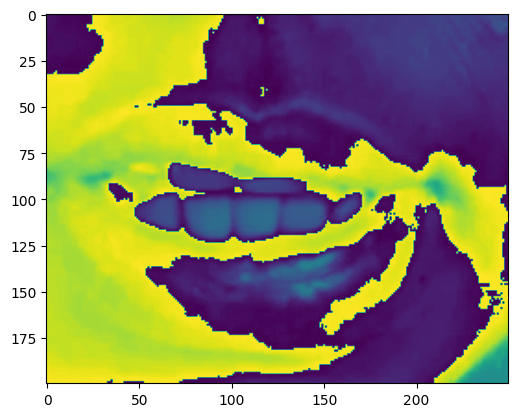

In [20]:
plt.imshow(frames[8])

In [21]:
alignments

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([14,  0,  0,  2,  0])>

In [22]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'\xe0\xb6\xaf\xe0\xb6\x9a'>

In [23]:
# num_to_char_result = num_to_char(alignments.numpy())
# tf.strings.reduce_join([char.decode('utf-8') for char in num_to_char_result.numpy()])

In [24]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [25]:
from matplotlib import pyplot as plt

In [26]:
data = tf.data.Dataset.list_files('./data/s1/*.mp4')
print(data)
data = data.shuffle(50, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([35,None,None,None],[14]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(35)
test = data.skip(10)

<_ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


In [27]:
len(test)

35

In [28]:
frames, alignments = data.as_numpy_iterator().next()

In [29]:
alignments

array([[14,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 5,  0, 13,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [30]:
len(frames)

2

In [31]:
sample = data.as_numpy_iterator()

In [32]:
val = sample.next();

In [33]:
# imageio.mimsave('./animation.gif', val[0][0], fps=10)

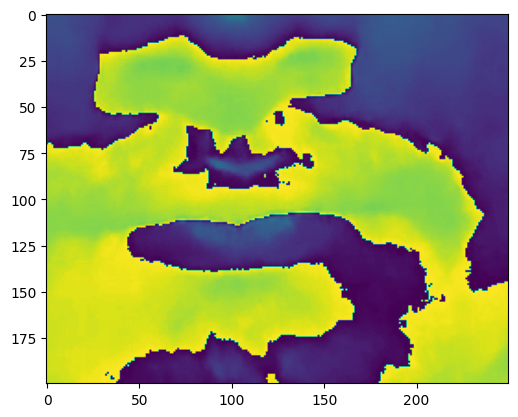

In [34]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video
plt.imshow(val[0][0][1])

In [35]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'\xe0\xb6\xaf\xe0\xb6\x9a'>

In [36]:
# num_to_char_result = tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])
# [char.decode('utf-8') for char in num_to_char_result.numpy()]

# 3. Design the Deep Neural Network

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import regularizers

In [38]:
# data.as_numpy_iterator().next()[0][0].shape

In [39]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(35,200,250,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(35, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

# model.add(TimeDistributed(Dense(1, activation='softmax')))

# model = Sequential()
# model.add(Conv3D(128, (3, 5, 7), input_shape=(35, 200, 250, 1), padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPool3D((1, 2, 2)))

# model.add(Conv3D(256, (3, 5, 7), padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPool3D((1, 2, 2)))

# model.add(Conv3D(75, (3, 5, 7), padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPool3D((1, 2, 2)))

# model.add(TimeDistributed(Flatten()))

# model.add(Bidirectional(LSTM(16, kernel_initializer='Orthogonal', return_sequences=True)))
# model.add(Dropout(0.5))

# model.add(Bidirectional(LSTM(16, kernel_initializer='Orthogonal', return_sequences=True)))
# model.add(Dropout(0.5))

# model.add(Bidirectional(LSTM(16, kernel_initializer='Orthogonal', return_sequences=True, recurrent_dropout=0.5)))

# model.add(Bidirectional(LSTM(16, kernel_initializer='Orthogonal', return_sequences=True, recurrent_dropout=0.5)))

# model.add(Dense(char_to_num.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax'))


In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 35, 200, 250, 12   3584      
                             8)                                  
                                                                 
 activation (Activation)     (None, 35, 200, 250, 12   0         
                             8)                                  
                                                                 
 max_pooling3d (MaxPooling3  (None, 35, 100, 125, 12   0         
 D)                          8)                                  
                                                                 
 conv3d_1 (Conv3D)           (None, 35, 100, 125, 25   884992    
                             6)                                  
                                                                 
 activation_1 (Activation)   (None, 35, 100, 125, 25   0

In [41]:
5*17*75

6375

In [42]:
yhat = model.predict(val[0])

1/1 [==============================] - 12s 12s/step


In [43]:
yhat.shape

(2, 35, 16)

In [44]:
# yhat[0]

In [45]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\xad\xe0\xb7\x94\xe0\xb6\xad\xe0\xb7\x94'>

In [46]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\x85\xe0\xb6\xad\xe0\xb7\x94\xe0\xb6\xad\xe0\xb7\x94'>

In [47]:
# b = tf.argmax(yhat[0],axis=1)
# b

In [48]:
# tf.argmax(b)

In [49]:
# tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

In [50]:
# tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

In [51]:
# num_to_char(tf.argmax(yhat[0],axis=1))

In [52]:
# tf.strings.reduce_join([num_to_char(tf.argmax(yhat[0],axis=1))])

In [53]:
# tf.strings.reduce_join([num_to_char(tf.argmax(yhat[0]))])

In [54]:
model.input_shape

(None, 35, 200, 250, 1)

In [55]:
model.output_shape

(None, 35, 16)

# 4. Setup Training Options and Train

In [56]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [57]:
def CTCLoss(y_true, y_pred):
    # print(y_true, "y_true")
    # print(y_pred, "y_pred")
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int32")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int32")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int32")
    # print(label_length, "label_length")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int32")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int32")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [58]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        # data = self.dataset.next()

        try:
            data = self.dataset.next()
        except StopIteration:  # Handle the end of the iterator
            self.dataset = self.dataset.repeat()
            self.dataset = self.dataset.as_numpy_iterator()  # Re-initialize the iterator
            data = self.dataset.next()

        yhat = self.model.predict(data[0])
        # print(data[1][:], "data")
        # print(yhat, "yhat_on_epoch_end")
        decoded = tf.keras.backend.ctc_decode(yhat, [35,35], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [59]:
model.compile(optimizer=Adam(learning_rate=0.0001, clipvalue=0.5), loss=CTCLoss)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy')

In [60]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)

In [61]:
schedule_callback = LearningRateScheduler(scheduler)

In [62]:
example_callback = ProduceExample(test)

In [63]:
tf.debugging.disable_traceback_filtering()

In [ ]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])
# model.fit(train, validation_data=test, epochs=100)

Epoch 1/100
1/1 [==============================] - 4s 4s/step
Original: හත
Prediction: 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: හතර
Prediction: 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
35/35 [==============================] - 210s 5s/step - loss: 18.0511 - val_loss: 14.0184 - lr: 1.0000e-04
Epoch 2/100
1/1 [==============================] - 1s 633ms/step
Original: හත
Prediction: 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: පහ
Prediction: 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
35/35 [==============================] - 152s 4s/step - loss: 13.6772 - val_loss: 12.4430 - lr: 1.0000e-04
Epoch 3/100
1/1 [==============================] - 1s 679ms/step
Original: එක
Prediction: 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# 5. Make a Prediction

In [ ]:
# url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
# output = 'checkpoints.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('checkpoints.zip', 'models')

In [ ]:
# model.load_weights('models/checkpoint')

In [ ]:
# test_data = test.as_numpy_iterator()

In [ ]:
# sample = test_data.next()

In [ ]:
# yhat = model.predict(sample[0])

In [ ]:
# print('~'*100, 'REAL TEXT')
# [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

In [ ]:
# decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
# print('~'*100, 'PREDICTIONS')
# [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

# Test on a Video

In [ ]:
sample = load_data(tf.convert_to_tensor('/content/data/s1/pamoda_7.mp4'))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

In [ ]:
[sample[1]]

In [ ]:
num_to_char_result = num_to_char(sample[1].numpy().tolist())
[char.decode('utf-8') for char in num_to_char_result.numpy()]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

In [ ]:
# yhat[0]

In [ ]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[35], greedy=True)[0][0].numpy()

In [ ]:
decoded

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

In [ ]:
a = (tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded)

In [ ]:
a

In [ ]:
# num_to_char_result =  num_to_char(decoded.numpy().tolist())
[char.decode('utf-8') for char in a.numpy()]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp -r /content/models /content/drive/MyDrive/research/models_2